# Test Target Model

In [1]:
from datasets import dataset_list
import pandas as pd
import joblib
import sglearn
import gpplot
import seaborn as sns

from model_predictions import (deepspcas9_predictions,
                               rule_set2_predictions,
                               vbc_predictions,
                               crispron_predictions)

import target_featurization as ft
from core import (setup_plots,
                  get_model_correlations,
                  get_model_rank_loss,
                  point_range_plot)

In [2]:
setup_plots()

## Import Data

In [3]:
nt_model = joblib.load('../models/RuleSet3.pkl')
target_model = joblib.load('../models/target_model.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')

In [4]:
dataset_activity_list = []
for ds in dataset_list:
    if ds.endogenous:
        ds.load_data()
        ds.set_sgrnas()
        dataset_activity = ds.get_sg_df(include_group=True, include_activity=True)
        dataset_activity['dataset'] = ds.name
        dataset_activity['genomewide'] = ds.genomewide
        design_df = ds.get_designs()
        dataset_activity = dataset_activity.merge(design_df, how='inner',
                                                  on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df = ft.add_target_columns(dataset_activity_df)  # only necessary for getting transcript bases
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,...,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes,AA Index,Transcript Base
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2017,True,ENSG00000111605,MAX,9606,...,140,76,1.0,1.0,96,48.0,2.0,Previously skipped due to: Spacing Violation: ...,123,ENST00000435070
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2017,True,ENSG00000165480,MAX,9606,...,58,29,1.0,1.0,37,23.0,2.0,Previously skipped due to: Spacing Violation: ...,258,ENST00000314759
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2017,True,ENSG00000021776,MAX,9606,...,179,115,1.0,1.0,88,235.0,3.0,Previously skipped due to: Outside Target Wind...,56,ENST00000156471
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2017,True,ENSG00000117174,MAX,9606,...,149,62,1.0,1.0,119,74.0,2.0,Previously skipped due to: Spacing Violation: ...,291,ENST00000370574
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2017,True,ENSG00000204574,MAX,9606,...,71,3,1.0,1.0,5,2.0,1.0,None,80,ENST00000326195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,-0.733651,Wang2014,False,ENSG00000147604,MAX,9606,...,68,76,1.0,1.0,75,65.0,5.0,Previously skipped due to: Off-target Match Bi...,34,ENST00000352983
25832,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.715594,Wang2014,False,ENSG00000147604,MAX,9606,...,47,72,1.0,1.0,67,57.0,5.0,Previously skipped due to: Off-target Match Bi...,232,ENST00000352983
25833,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,-1.302978,Wang2014,False,ENSG00000198034,MAX,9606,...,90,84,1.0,1.0,98,93.0,5.0,Previously skipped due to: Off-target Match Bi...,249,ENST00000316084
25834,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,-1.341252,Wang2014,False,ENSG00000161016,MAX,9606,...,101,8,1.0,1.0,47,38.0,2.0,Previously skipped due to: Spacing Violation: ...,92,ENST00000262584


In [5]:
transcript_bases = list(dataset_activity_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

## Get Predictions

### External Models

In [6]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions,
                         vbc_predictions,
                         crispron_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.set_sgrnas()
    if model_prediction.target_col is None:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        on=['sgRNA Sequence',
                                                            'sgRNA Context Sequence',
                                                            'PAM Sequence'])
    else:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        left_on=['sgRNA Sequence',
                                                                 'sgRNA Context Sequence',
                                                                 'PAM Sequence',
                                                                 'sgRNA Target'],
                                                        right_on=['sgRNA Sequence',
                                                                  'sgRNA Context Sequence',
                                                                  'PAM Sequence',
                                                                  model_prediction.target_col])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,...,Rule Set 2,Rule Set 2 train,gene,VBC score,VBC Activity,VBC Bioscore,genome,VBC score train,CRISPRon,CRISPRon train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2017,True,ENSG00000111605,MAX,9606,...,0.489201,False,CPSF6,0.621,0.436,0.695,hg38,False,13.88,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2017,True,ENSG00000165480,MAX,9606,...,0.464962,False,SKA3,0.486,0.320,0.465,hg38,False,3.39,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2017,True,ENSG00000021776,MAX,9606,...,0.525786,False,AQR,0.665,0.551,0.613,hg38,False,27.21,False
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2017,True,ENSG00000117174,MAX,9606,...,0.369761,False,ZNHIT6,0.549,0.358,0.580,hg38,False,14.67,False
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2017,True,ENSG00000204574,MAX,9606,...,0.604568,False,ABCF1,0.592,0.657,0.428,hg38,False,44.40,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26356,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,-0.733651,Wang2014,False,ENSG00000147604,MAX,9606,...,0.333939,False,RPL7,0.534,0.335,0.582,hg38,False,18.36,False
26357,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.715594,Wang2014,False,ENSG00000147604,MAX,9606,...,0.489867,False,RPL7,0.565,0.549,0.516,hg38,False,42.03,False
26358,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,-1.302978,Wang2014,False,ENSG00000198034,MAX,9606,...,0.445911,False,RPS4X,0.506,0.331,0.572,hg38,False,37.53,False
26359,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,-1.341252,Wang2014,False,ENSG00000161016,MAX,9606,...,0.472521,False,RPL8,0.489,0.403,0.444,hg38,False,30.27,False


In [7]:
model_prediction_names = [m.name for m in model_prediction_list]
dataset_activity_df[model_prediction_names].isna().sum()

DeepSpCas9       0
Rule Set 2       0
VBC score     1549
CRISPRon         0
dtype: int64

### Rule Set 3

In [8]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = sglearn.featurize_guides(dataset_activity_df['sgRNA Context Sequence'])
dataset_activity_df['Rule Set 3'] = nt_model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,...,gene,VBC score,VBC Activity,VBC Bioscore,genome,VBC score train,CRISPRon,CRISPRon train,Rule Set 3,Rule Set 3 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2017,True,ENSG00000111605,MAX,9606,...,CPSF6,0.621,0.436,0.695,hg38,False,13.88,False,-1.143076,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2017,True,ENSG00000165480,MAX,9606,...,SKA3,0.486,0.320,0.465,hg38,False,3.39,False,-1.203468,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2017,True,ENSG00000021776,MAX,9606,...,AQR,0.665,0.551,0.613,hg38,False,27.21,False,-0.455462,False
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2017,True,ENSG00000117174,MAX,9606,...,ZNHIT6,0.549,0.358,0.580,hg38,False,14.67,False,-1.152199,False
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2017,True,ENSG00000204574,MAX,9606,...,ABCF1,0.592,0.657,0.428,hg38,False,44.40,False,-0.452622,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26356,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,-0.733651,Wang2014,False,ENSG00000147604,MAX,9606,...,RPL7,0.534,0.335,0.582,hg38,False,18.36,False,-0.924727,True
26357,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.715594,Wang2014,False,ENSG00000147604,MAX,9606,...,RPL7,0.565,0.549,0.516,hg38,False,42.03,False,-0.065532,True
26358,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,-1.302978,Wang2014,False,ENSG00000198034,MAX,9606,...,RPS4X,0.506,0.331,0.572,hg38,False,37.53,False,-0.235396,True
26359,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,-1.341252,Wang2014,False,ENSG00000161016,MAX,9606,...,RPL8,0.489,0.403,0.444,hg38,False,30.27,False,-0.386149,True


### Rule Set 3 Target

In [9]:
target_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
               'Orientation', 'Target Cut %', 'Target Cut Length',
               'Target Transcript']  # Note don't need Transcript Base and AA Index
unique_activity = dataset_activity_df[target_cols].drop_duplicates()
target_feature_df, target_feature_cols = ft.build_target_feature_df(unique_activity,
                                                                    features=['position', 'aa',
                                                                              'domain'],
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df)
X_target = target_feature_df[target_feature_cols]
unique_activity['Target Score'] = target_model.predict(X_target)
dataset_activity_df = (dataset_activity_df.merge(unique_activity, how='left',
                                                 on=target_cols))
dataset_activity_df['Rule Set 3 Target'] = (dataset_activity_df['Rule Set 3'] +
                                            dataset_activity_df['Target Score'])
dataset_activity_df['Rule Set 3 Target train'] = dataset_activity_df['Rule Set 3 train']

### Performance

In [10]:
score_cols = ['Rule Set 3', 'Rule Set 3 Target'] + model_prediction_names
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = (filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                       'PAM Sequence', 'sgRNA Activity',
                                                       'sgRNA Target', 'dataset', 'genomewide'],
                                              value_vars=score_cols,
                                              var_name='model',
                                              value_name='prediction')
                    .dropna())

In [11]:
cor_performance_ci = get_model_correlations(long_predictions)

100%|██████████| 1000/1000 [02:37<00:00,  6.36it/s]


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_rs3_performance.pdf


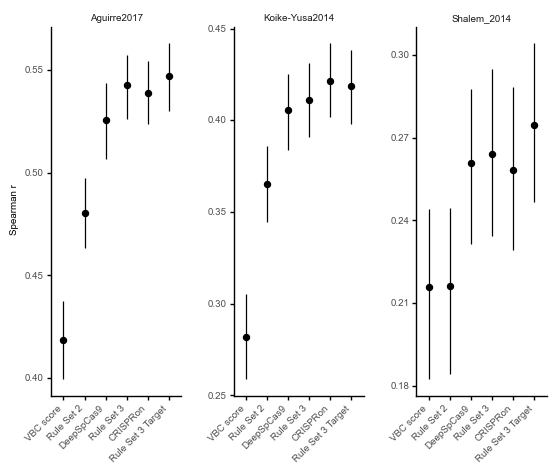

<ggplot: (8781136917520)>

In [12]:
g = point_range_plot(cor_performance_ci, 'model', 'spearman',
                     'spearman_025', 'spearman_975', xlabel='',
                     ylabel='Spearman r', wspace=0.4)
g.save('../figures/target_rs3_performance.pdf', width=4, height=3)
g

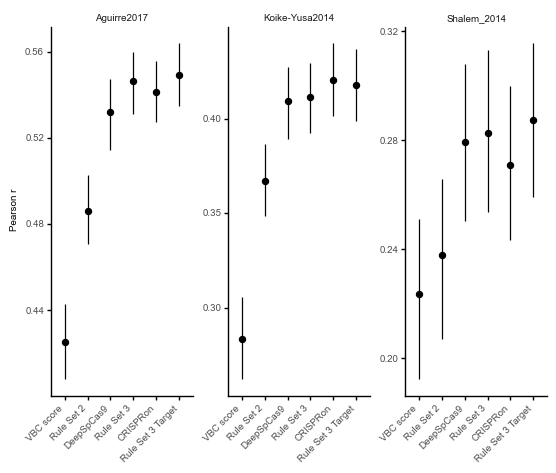

<ggplot: (8781089709809)>

In [13]:
point_range_plot(cor_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975', xlabel='',
                 ylabel='Pearson r')

In [14]:
genomewide_predictions = long_predictions[long_predictions.genomewide].copy()
rank_loss_performance_ci = get_model_rank_loss(genomewide_predictions)

100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]


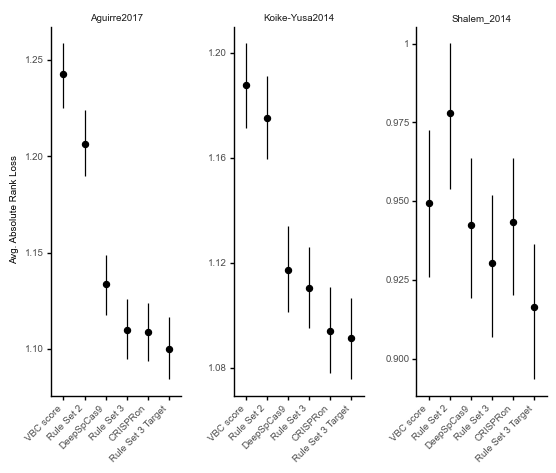

<ggplot: (8781061828575)>

In [15]:
g = point_range_plot(rank_loss_performance_ci, 'model', 'avg_abs_rank_diff',
                     'avg_abs_rank_diff_025', 'avg_abs_rank_diff_975', xlabel='',
                     ylabel='Avg. Absolute Rank Loss', wspace=0.4)
g

## Comparison With Bioscore

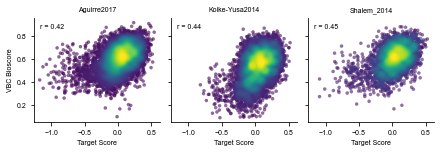

In [16]:
def scatter_density(data, x, y, **kwargs):
    gpplot.point_densityplot(data[[x, y]].dropna(), x, y, **kwargs)
    gpplot.add_correlation(data[[x, y]].dropna(), x, y)

g = sns.FacetGrid(data=filtered_predictions,
                  col='dataset', aspect=1, height=2)
g.map_dataframe(scatter_density, x='Target Score', y='VBC Bioscore',
                s=10)
g.set_xlabels('Target Score')
g.set_ylabels('VBC Bioscore')
g.set_titles(col_template='{col_name}')
gpplot.savefig('../figures/target_model_bioscore_comparison.pdf', dpi=300)